In [7]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from datetime import datetime
from pymongo import MongoClient
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [8]:
class WebScraping:
    def __init__(self):
        print("Object created")
        self.client = MongoClient("mongodb://localhost:27017")
        self.db = self.client["Big"]

    def clean_value(self, value):
        if pd.isna(value):
            return None
        if isinstance(value, np.integer):
            return int(value)
        if isinstance(value, np.floating):
            return float(value)
        return value

    def scrape(self, url):
        print(f"Scraping: {url}")

        options = webdriver.ChromeOptions()
        options.add_argument("--start-maximized")
        # Optional: Add headless mode if you want (remove if you want to see browser)
        # options.add_argument("--headless")

        driver = webdriver.Chrome(options=options)
        driver.get(url)
        
        # Wait for initial page load and first cards to appear
        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, '[data-testid="card-content"]'))
            )
        except:
            print("  ⚠ Initial cards not found, continuing anyway...")
        
        time.sleep(2)

        # -------------------------------
        # IMPROVED SCROLLING - Scroll incrementally and wait for cards
        # -------------------------------
        previous_card_count = 0
        no_change_count = 0
        max_no_change = 3  # Stop if no new cards appear after 3 scrolls
        
        for scroll_iteration in range(15):  # Max 15 scroll iterations
            # Get current card count
            current_cards = driver.find_elements(By.CSS_SELECTOR, '[data-testid="card-content"]')
            current_card_count = len(current_cards)
            
            print(f"  Scroll {scroll_iteration + 1}: Found {current_card_count} cards so far")
            
            # If no new cards appeared, increment counter
            if current_card_count == previous_card_count:
                no_change_count += 1
                if no_change_count >= max_no_change:
                    print(f"  → No new cards after {max_no_change} scrolls, stopping")
                    break
            else:
                no_change_count = 0  # Reset counter if new cards appeared
            
            previous_card_count = current_card_count
            
            # Scroll down incrementally (not all at once)
            scroll_pause = 2
            driver.execute_script("window.scrollBy(0, 800);")  # Scroll 800px at a time
            time.sleep(scroll_pause)
            
            # Also try scrolling to bottom occasionally
            if scroll_iteration % 3 == 0:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(1)
        
        # Final scroll to bottom and wait
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(3)
        
        # One more check - scroll back up a bit and down again to trigger any remaining lazy loads
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight * 0.8);")
        time.sleep(1)
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
        # -------------------------------

        # Get final card count
        final_cards = driver.find_elements(By.CSS_SELECTOR, '[data-testid="card-content"]')
        print(f"  → Final card count before extraction: {len(final_cards)}")

        html = driver.page_source
        cards_found = self.extract_data(html)
        print(f"  → Extracted {cards_found} properties from this page\n")

        driver.quit()

    def extract_data(self, html):
        soup = BeautifulSoup(html, "html.parser")
        cards = soup.find_all("div", {"data-testid": "card-content"})
        
        print(f"  → Found {len(cards)} card elements in HTML")

        cards_processed = 0
        for card in cards:
            try:
                beds = baths = sqft = lot_sqft = price = np.nan

                # Beds
                beds_li = card.find("li", {"data-testid": "property-meta-beds"})
                if beds_li:
                    span = beds_li.find("span", {"data-testid": "meta-value"})
                    if span:
                        text = span.text.strip().lower()
                        beds = 0 if text == "studio" else pd.to_numeric(text, errors="coerce")

                # Baths
                baths_li = card.find("li", {"data-testid": "property-meta-baths"})
                if baths_li:
                    span = baths_li.find("span", {"data-testid": "meta-value"})
                    if span:
                        baths = pd.to_numeric(span.text, errors="coerce")

                # Sqft
                sqft_li = card.find("li", {"data-testid": "property-meta-sqft"})
                if sqft_li:
                    span = sqft_li.find("span", {"data-testid": "meta-value"})
                    if span:
                        sqft = pd.to_numeric(span.text.replace(",", ""), errors="coerce")

                # Lot Sqft
                lot_li = card.find("li", {"data-testid": "property-meta-lot-size"})
                if lot_li:
                    span = lot_li.find("span", {"data-testid": "meta-value"})
                    if span:
                        lot_sqft = pd.to_numeric(span.text.replace(",", ""), errors="coerce")

                # Address
                address = None
                addr1 = card.find("div", {"data-testid": "card-address-1"})
                addr2 = card.find("div", {"data-testid": "card-address-2"})
                if addr1 and addr2:
                    address = f"{addr1.text.strip()}, {addr2.text.strip()}"
                elif addr1:
                    address = addr1.text.strip()
                elif addr2:
                    address = addr2.text.strip()

                # Price
                price_div = card.find("div", {"data-testid": "card-price"})
                if price_div:
                    span = price_div.find("span", class_=lambda x: x and "base_StyledType" in str(x))
                    if not span:
                        span = price_div.find("span")
                    if span:
                        price = pd.to_numeric(
                            span.text.replace("$", "").replace(",", "").strip(),
                            errors="coerce"
                        )

                document = {
                    "beds": self.clean_value(beds),
                    "baths": self.clean_value(baths),
                    "sqft": self.clean_value(sqft),
                    "lot_sqft": self.clean_value(lot_sqft),
                    "address": address,
                    "price": self.clean_value(price),
                    "scraped_at": datetime.now()
                }

                self.db.real_estate.insert_one(document)
                cards_processed += 1
                
            except Exception as e:
                print(f"  ⚠ Error processing card: {e}")
                continue

        return cards_processed

In [9]:
# RUN SCRAPER
ws = WebScraping()
for page in range(1, 22):
    url = f"https://www.realtor.com/realestateforsale?page={page}"
    ws.scrape(url)


Object created
Scraping: https://www.realtor.com/realestateforsale?page=1
  Scroll 1: Found 4 cards so far
  Scroll 2: Found 8 cards so far
  Scroll 3: Found 8 cards so far
  Scroll 4: Found 8 cards so far
  Scroll 5: Found 8 cards so far
  → No new cards after 3 scrolls, stopping
  → Final card count before extraction: 8
  → Found 8 card elements in HTML
  → Extracted 8 properties from this page

Scraping: https://www.realtor.com/realestateforsale?page=2
  Scroll 1: Found 4 cards so far
  Scroll 2: Found 8 cards so far
  Scroll 3: Found 8 cards so far
  Scroll 4: Found 8 cards so far
  Scroll 5: Found 8 cards so far
  → No new cards after 3 scrolls, stopping
  → Final card count before extraction: 8
  → Found 8 card elements in HTML
  → Extracted 8 properties from this page

Scraping: https://www.realtor.com/realestateforsale?page=3
  Scroll 1: Found 4 cards so far
  Scroll 2: Found 8 cards so far
  Scroll 3: Found 8 cards so far
  Scroll 4: Found 8 cards so far
  Scroll 5: Found 8 ca

In [8]:
# After scraping, check what you have
from pymongo import MongoClient
client = MongoClient("mongodb://localhost:27017")
db = client["Big"]
count = db.real_estate.count_documents({})
print(f"\nTotal documents in database: {count}")


Total documents in database: 168


LOAD DATA FROM MONGODB INTO PANDAS

In [9]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017")
db = client["Big"]

# Load collection into a list of dictionaries
cursor = db.real_estate.find()

# Convert to DataFrame
df = pd.DataFrame(list(cursor))

# Drop MongoDB internal ID
df.drop(columns=["_id"], inplace=True)

# Preview data
df.head()


,beds,baths,sqft,lot_sqft,address,price,scraped_at
0,4.0,2.5,2527.0,6490.00,"131 Clover Crk, San Antonio, TX 78245",280000,2026-01-22 00:36:55.176
1,3.0,2.5,1707.0,8146.00,"511 Millwood Ln, San Antonio, TX 78216",280000,2026-01-22 00:36:55.241
2,3.0,2.0,1601.0,5097.00,"5306 Tomas Cir, San Antonio, TX 78240",295000,2026-01-22 00:36:55.252
3,5.0,2.5,2580.0,4966.00,"2619 Gato Del Sol, San Antonio, TX 78245",250000,2026-01-22 00:36:55.260
4,4.0,3.5,4028.0,0.62,"23202 Walker Rdg, San Antonio, TX 78255",1450000,2026-01-22 00:36:55.263


In [10]:
df.dropna(subset=['price', 'sqft', 'lot_sqft', 'beds', 'baths'], inplace=True)

In [11]:
df

,beds,baths,sqft,lot_sqft,address,price,scraped_at
0,4.0,2.5,2527.0,6490.00,"131 Clover Crk, San Antonio, TX 78245",280000,2026-01-22 00:36:55.176
1,3.0,2.5,1707.0,8146.00,"511 Millwood Ln, San Antonio, TX 78216",280000,2026-01-22 00:36:55.241
2,3.0,2.0,1601.0,5097.00,"5306 Tomas Cir, San Antonio, TX 78240",295000,2026-01-22 00:36:55.252
3,5.0,2.5,2580.0,4966.00,"2619 Gato Del Sol, San Antonio, TX 78245",250000,2026-01-22 00:36:55.260
4,4.0,3.5,4028.0,0.62,"23202 Walker Rdg, San Antonio, TX 78255",1450000,2026-01-22 00:36:55.263
...,...,...,...,...,...,...,...
163,4.0,2.5,2150.0,0.46,"9911 Atkins Ridge Dr, Charlotte, NC 28213",345000,2026-01-22 00:48:14.178
164,3.0,2.0,1251.0,0.25,"7125 Falconwood Ct, Charlotte, NC 28227",319900,2026-01-22 00:48:14.182
165,4.0,3.5,2913.0,1.83,"Brief Rd, Charlotte, NC 28227",950000,2026-01-22 00:48:14.184
166,4.0,2.5,2190.0,7754.00,"539 Dawn Cir, Charlotte, NC 28213",450000,2026-01-22 00:48:14.185


In [12]:
# Conversion factor
sqft_to_sqm = 0.09290304

# Add new columns
df['sqm'] = (df['sqft'] * sqft_to_sqm).round(2)
df['sqm_lot'] = (df['lot_sqft'] * sqft_to_sqm).round(2)

# Optional: View the updated table
df.head()

,beds,baths,sqft,lot_sqft,address,price,scraped_at,sqm,sqm_lot
0,4.0,2.5,2527.0,6490.00,"131 Clover Crk, San Antonio, TX 78245",280000,2026-01-22 00:36:55.176,234.77,602.94
1,3.0,2.5,1707.0,8146.00,"511 Millwood Ln, San Antonio, TX 78216",280000,2026-01-22 00:36:55.241,158.59,756.79
2,3.0,2.0,1601.0,5097.00,"5306 Tomas Cir, San Antonio, TX 78240",295000,2026-01-22 00:36:55.252,148.74,473.53
3,5.0,2.5,2580.0,4966.00,"2619 Gato Del Sol, San Antonio, TX 78245",250000,2026-01-22 00:36:55.260,239.69,461.36
4,4.0,3.5,4028.0,0.62,"23202 Walker Rdg, San Antonio, TX 78255",1450000,2026-01-22 00:36:55.263,374.21,0.06


In [13]:
#Drop sqft and lot_sqft
df.drop(columns=['sqft', 'lot_sqft'], inplace=True)

In [14]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["Big"]
collection = db["real_estate_processed"]
collection.insert_many(df.to_dict("records"))

print("Done! Collection 'real_estate_processed' is ready.")

Done! Collection 'real_estate_processed' is ready.


In [15]:
df.head()

,beds,baths,address,price,scraped_at,sqm,sqm_lot
0,4.0,2.5,"131 Clover Crk, San Antonio, TX 78245",280000,2026-01-22 00:36:55.176,234.77,602.94
1,3.0,2.5,"511 Millwood Ln, San Antonio, TX 78216",280000,2026-01-22 00:36:55.241,158.59,756.79
2,3.0,2.0,"5306 Tomas Cir, San Antonio, TX 78240",295000,2026-01-22 00:36:55.252,148.74,473.53
3,5.0,2.5,"2619 Gato Del Sol, San Antonio, TX 78245",250000,2026-01-22 00:36:55.260,239.69,461.36
4,4.0,3.5,"23202 Walker Rdg, San Antonio, TX 78255",1450000,2026-01-22 00:36:55.263,374.21,0.06


In [33]:
df.describe()

,beds,baths,price,scraped_at,sqm,sqm_lot
count,161.000000,161.000000,1.610000e+02,161,161.000000,161.000000
mean,3.826087,2.695652,4.842957e+05,2026-01-22 00:42:48.204739328,207.312174,322.570435
min,3.000000,2.000000,1.980000e+05,2026-01-22 00:36:55.176000,116.220000,0.020000
25%,3.000000,2.500000,3.199000e+05,2026-01-22 00:39:49.126000128,158.590000,0.030000
50%,4.000000,2.500000,4.150000e+05,2026-01-22 00:42:39.632999936,199.740000,364.640000
75%,4.000000,2.500000,4.890000e+05,2026-01-22 00:45:26.840000,239.690000,663.700000
max,5.000000,4.500000,1.450000e+06,2026-01-22 00:48:14.187000,374.210000,756.790000
std,0.638017,0.705279,2.775916e+05,NaN,65.835727,321.755707


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161 entries, 0 to 167
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   beds        161 non-null    float64       
 1   baths       161 non-null    float64       
 2   address     161 non-null    object        
 3   price       161 non-null    int64         
 4   scraped_at  161 non-null    datetime64[ns]
 5   sqm         161 non-null    float64       
 6   sqm_lot     161 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 10.1+ KB


In [36]:
df.isnull().sum()

beds          0
baths         0
address       0
price         0
scraped_at    0
sqm           0
sqm_lot       0
dtype: int64

In [16]:
len(df)

161

In [17]:
df.shape

(161, 7)

<Axes: xlabel='sqm', ylabel='price'>

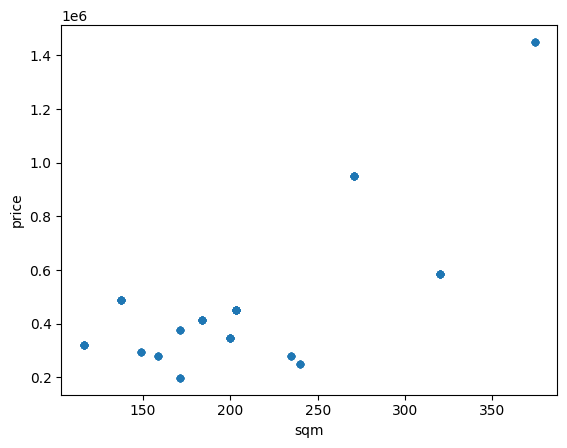

In [18]:
df.plot(kind='scatter',x='sqm',y='price')

In [19]:
df[['price', 'sqm']].corr()

,price,sqm
price,1.00000,0.71822
sqm,0.71822,1.00000


<Axes: xlabel='sqm_lot', ylabel='price'>

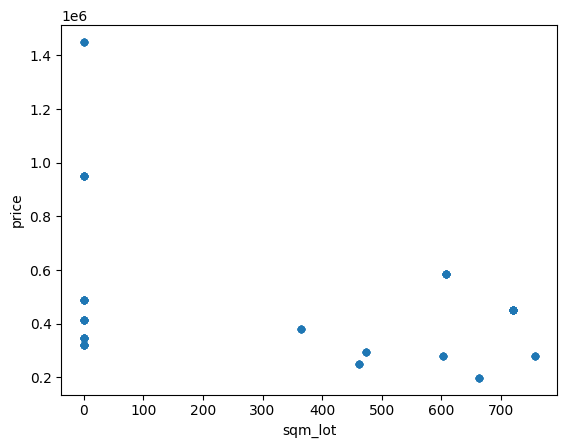

In [20]:
df.plot(kind='scatter',x='sqm_lot',y='price')

In [21]:
df[['price', 'sqm_lot']].corr()

,price,sqm_lot
price,1.000000,-0.333407
sqm_lot,-0.333407,1.000000


# Linear regression model with four variables 

In [25]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
from pymongo import MongoClient
import numpy as np


class PricePredictor():
    def __init__(self):
        self.client = MongoClient('mongodb://localhost:27017')
        self.db = self.client['Big']

        self.scaler1 = StandardScaler()
        self.scaler2 = StandardScaler()
        self.scaler3 = StandardScaler()
        self.scaler4 = StandardScaler()

    def train_the_model(self):
        print("Training the models")

        # Load data
        self.df = pd.DataFrame(list(self.db.real_estate_processed.find({})))

        if '_id' in self.df.columns:
            self.df.drop(columns=['_id'], inplace=True)

        self.df.dropna(inplace=True)

        # Target variable
        y = self.df['price'].values.reshape(-1, 1)

        # ---------------- MODEL 1 ----------------
        X1 = self.df[['sqm']]
        X1_train, X1_test, y_train, y_test = train_test_split(
            X1, y, test_size=0.2, random_state=42
        )

        X1_train_scaled = self.scaler1.fit_transform(X1_train)
        X1_test_scaled = self.scaler1.transform(X1_test)

        self.model1 = linear_model.LinearRegression()
        self.model1.fit(X1_train_scaled, y_train)

        self.evaluate_model("Model 1 (sqm)", self.model1, X1_test_scaled, y_test)

        # ---------------- MODEL 2 ----------------
        X2 = self.df[['sqm', 'beds']]
        X2_train, X2_test, y_train, y_test = train_test_split(
            X2, y, test_size=0.2, random_state=42
        )

        X2_train_scaled = self.scaler2.fit_transform(X2_train)
        X2_test_scaled = self.scaler2.transform(X2_test)

        self.model2 = linear_model.LinearRegression()
        self.model2.fit(X2_train_scaled, y_train)

        self.evaluate_model("Model 2 (sqm + beds)", self.model2, X2_test_scaled, y_test)

        # ---------------- MODEL 3 ----------------
        X3 = self.df[['sqm', 'beds', 'baths']]
        X3_train, X3_test, y_train, y_test = train_test_split(
            X3, y, test_size=0.2, random_state=42
        )

        X3_train_scaled = self.scaler3.fit_transform(X3_train)
        X3_test_scaled = self.scaler3.transform(X3_test)

        self.model3 = linear_model.LinearRegression()
        self.model3.fit(X3_train_scaled, y_train)

        self.evaluate_model("Model 3 (sqm + beds + baths)", self.model3, X3_test_scaled, y_test)

        # ---------------- MODEL 4 ----------------
        X4 = self.df[['sqm', 'beds', 'baths', 'sqm_lot']]
        X4_train, X4_test, y_train, y_test = train_test_split(
            X4, y, test_size=0.2, random_state=42
        )

        X4_train_scaled = self.scaler4.fit_transform(X4_train)
        X4_test_scaled = self.scaler4.transform(X4_test)

        self.model4 = linear_model.LinearRegression()
        self.model4.fit(X4_train_scaled, y_train)

        self.evaluate_model(
            "Model 4 (sqm + beds + baths + sqm_lot)",
            self.model4,
            X4_test_scaled,
            y_test
        )

    # ---------------- EVALUATION ----------------
    def evaluate_model(self, name, model, X_test, y_test):
        predictions = model.predict(X_test)
    
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
        print(f"\n{name}")
        print(f"R² Score: {r2:.3f}")
        print(f"MAE: {mae:,.2f}")
        print(f"RMSE: {rmse:,.2f}")


    # ---------------- PREDICTIONS ----------------
    def predict_the_price(self, sqm):
        X = self.scaler1.transform([[sqm]])
        print(self.model1.predict(X))

    def predict_the_price2(self, sqm, beds):
        X = self.scaler2.transform([[sqm, beds]])
        print(self.model2.predict(X))

    def predict_the_price3(self, sqm, beds, baths):
        X = self.scaler3.transform([[sqm, beds, baths]])
        print(self.model3.predict(X))

    def predict_the_price4(self, sqm, beds, baths, sqm_lot):
        X = self.scaler4.transform([[sqm, beds, baths, sqm_lot]])
        print(self.model4.predict(X))


In [26]:
pp = PricePredictor()

# Train all models (with scaling, split, evaluation)
pp.train_the_model()

# Predictions
pp.predict_the_price(234.77)                 # sqm
pp.predict_the_price2(234.77, 4)             # sqm, beds
pp.predict_the_price3(234.77, 4, 2.5)          # sqm, beds, baths
pp.predict_the_price4(234.77, 4, 2.5, 602.94)     # sqm, beds, baths, sqm_lot

# Optional: inspect data
# pp.df.sample(3)


Training the models

Model 1 (sqm)
R² Score: 0.531
MAE: 171,509.10
RMSE: 218,366.79

Model 2 (sqm + beds)
R² Score: 0.833
MAE: 107,803.27
RMSE: 130,331.60

Model 3 (sqm + beds + baths)
R² Score: 0.831
MAE: 107,415.19
RMSE: 131,048.31

Model 4 (sqm + beds + baths + sqm_lot)
R² Score: 0.879
MAE: 96,716.09
RMSE: 110,732.85
[[558017.1001088]]
[[573031.99679636]]
[[598299.02836866]]
[[532098.29502705]]


C:\Users\Mr_Life\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Mr_Life\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Mr_Life\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Mr_Life\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Training the models

Model 1 (sqm)
R² Score: 0.531
MAE: 171,509.10
RMSE: 218,366.79

Model 2 (sqm + beds)
R² Score: 0.833
MAE: 107,803.27
RMSE: 130,331.60

Model 3 (sqm + beds + baths)
R² Score: 0.831
MAE: 107,415.19
RMSE: 131,048.31

Model 4 (sqm + beds + baths + sqm_lot)
R² Score: 0.879
MAE: 96,716.09
RMSE: 110,732.85
LINEAR REGRESSION MODEL EVALUATION

Model 1 (sqm only):
  R² Score: 0.5307
  MAE: $171,509.10
  RMSE: $218,366.79
  Mean Price: $527,703.08
  MAE as % of Mean: 32.50%

Model 2 (sqm + beds):
  R² Score: 0.8328
  MAE: $107,803.27
  RMSE: $130,331.60
  Mean Price: $527,703.08
  MAE as % of Mean: 20.43%

Model 3 (sqm + beds + baths):
  R² Score: 0.8310
  MAE: $107,415.19
  RMSE: $131,048.31
  Mean Price: $527,703.08
  MAE as % of Mean: 20.36%

Model 4 (sqm + beds + baths + sqm_lot):
  R² Score: 0.8793
  MAE: $96,716.09
  RMSE: $110,732.85
  Mean Price: $527,703.08
  MAE as % of Mean: 18.33%


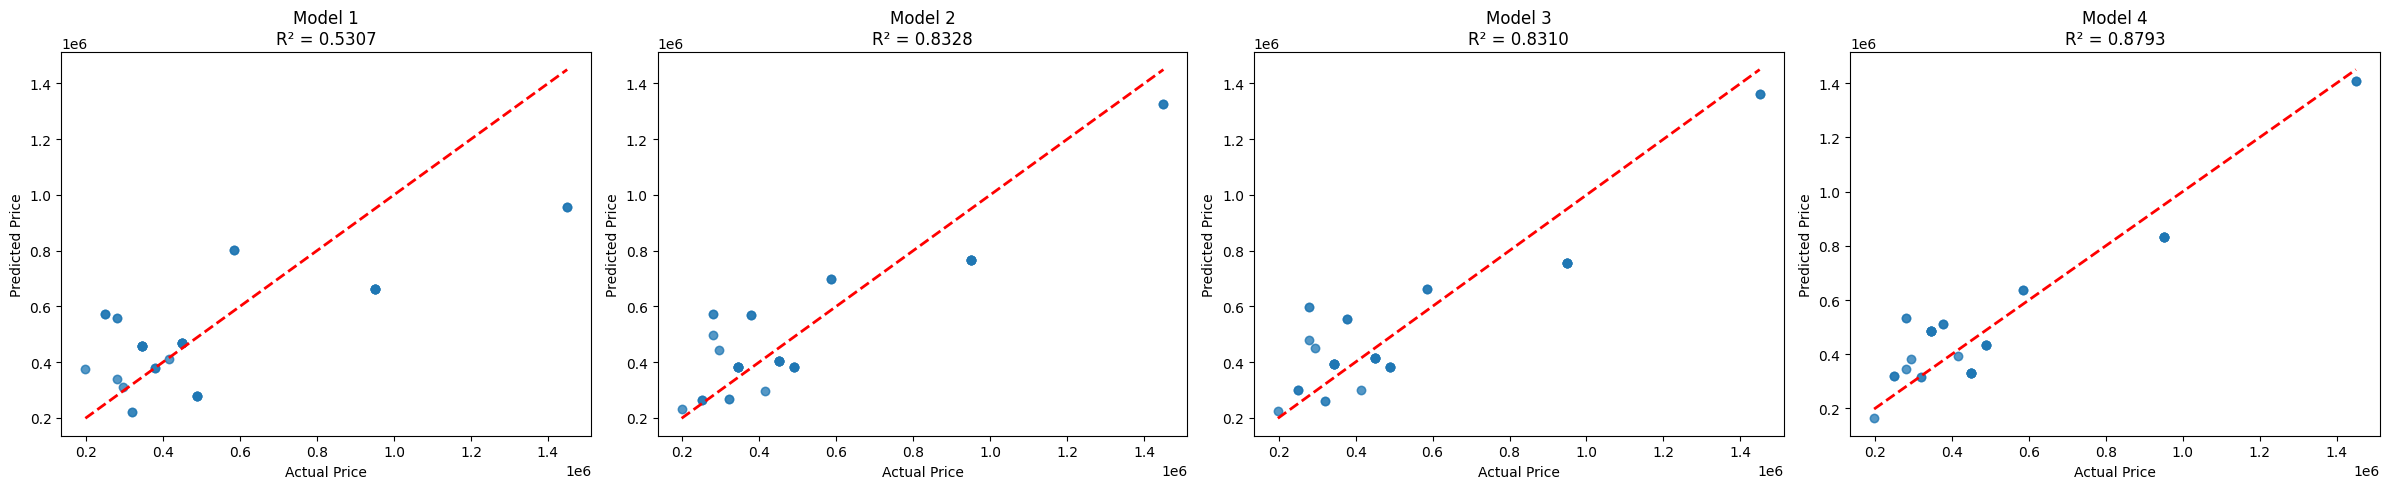


ACCURACY ASSESSMENT:
✓ R² ≥ 0.7: Model has good predictive power
   → Advanced models may still provide marginal improvements


In [28]:
# ============================================
# MODEL EVALUATION & COMPARISON
# ============================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np

# Re-initialize and train
pp = PricePredictor()
pp.train_the_model()

# Prepare data
X = pp.df[['sqm', 'beds', 'baths', 'sqm_lot']]
y = pp.df['price']

# Train/Test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature subsets
X1_train = X_train[['sqm']]
X1_test  = X_test[['sqm']]

X2_train = X_train[['sqm', 'beds']]
X2_test  = X_test[['sqm', 'beds']]

X3_train = X_train[['sqm', 'beds', 'baths']]
X3_test  = X_test[['sqm', 'beds', 'baths']]

X4_train = X_train
X4_test  = X_test

# Scalers
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()

X1_train = scaler1.fit_transform(X1_train)
X1_test  = scaler1.transform(X1_test)

X2_train = scaler2.fit_transform(X2_train)
X2_test  = scaler2.transform(X2_test)

X3_train = scaler3.fit_transform(X3_train)
X3_test  = scaler3.transform(X3_test)

X4_train = scaler4.fit_transform(X4_train)
X4_test  = scaler4.transform(X4_test)

# Train models
model1 = linear_model.LinearRegression().fit(X1_train, y_train)
model2 = linear_model.LinearRegression().fit(X2_train, y_train)
model3 = linear_model.LinearRegression().fit(X3_train, y_train)
model4 = linear_model.LinearRegression().fit(X4_train, y_train)

# Predictions
y_pred1 = model1.predict(X1_test)
y_pred2 = model2.predict(X2_test)
y_pred3 = model3.predict(X3_test)
y_pred4 = model4.predict(X4_test)

# Metrics
def metrics(y_true, y_pred):
    return (
        r2_score(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred))
    )

r2_1, mae1, rmse1 = metrics(y_test, y_pred1)
r2_2, mae2, rmse2 = metrics(y_test, y_pred2)
r2_3, mae3, rmse3 = metrics(y_test, y_pred3)
r2_4, mae4, rmse4 = metrics(y_test, y_pred4)

print("=" * 60)
print("LINEAR REGRESSION MODEL EVALUATION")
print("=" * 60)

def print_metrics(name, r2, mae, rmse):
    print(f"\n{name}:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  Mean Price: ${y_test.mean():,.2f}")
    print(f"  MAE as % of Mean: {(mae/y_test.mean()*100):.2f}%")

print_metrics("Model 1 (sqm only)", r2_1, mae1, rmse1)
print_metrics("Model 2 (sqm + beds)", r2_2, mae2, rmse2)
print_metrics("Model 3 (sqm + beds + baths)", r2_3, mae3, rmse3)
print_metrics("Model 4 (sqm + beds + baths + sqm_lot)", r2_4, mae4, rmse4)

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(24, 5))
models = [
    (y_pred1, r2_1, "Model 1"),
    (y_pred2, r2_2, "Model 2"),
    (y_pred3, r2_3, "Model 3"),
    (y_pred4, r2_4, "Model 4"),
]

for ax, (pred, r2, title) in zip(axes, models):
    ax.scatter(y_test, pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel("Actual Price")
    ax.set_ylabel("Predicted Price")
    ax.set_title(f"{title}\nR² = {r2:.4f}")

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("ACCURACY ASSESSMENT:")
print("=" * 60)

best_r2 = max(r2_1, r2_2, r2_3, r2_4)

if best_r2 < 0.5:
    print("⚠️  R² < 0.5: Model has poor predictive power")
    print("   → Consider using advanced models (XGBoost / LightGBM / CatBoost)")
elif best_r2 < 0.7:
    print("⚠️  R² < 0.7: Model has moderate predictive power")
    print("   → Advanced models may improve accuracy significantly")
else:
    print("✓ R² ≥ 0.7: Model has good predictive power")
    print("   → Advanced models may still provide marginal improvements")


In [30]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

models = {
    "RandomForest": RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=100, learning_rate=0.1, depth=6, random_seed=42, verbose=False)
}

results = {}

for name, model in models.items():
    model.fit(X4_train, y_train)           # use the same scaled X4 (or even try unscaled — trees don't need scaling)
    y_pred = model.predict(X4_test)
    
    r2   = r2_score(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = (r2, mae, rmse)
    
    print(f"\n{name}:")
    print(f" R²    = {r2:.4f}")
    print(f" MAE   = ${mae:,.0f}")
    print(f" RMSE  = ${rmse:,.0f}")
    print(f" MAE % = {mae / y_test.mean() * 100:.2f}%")


RandomForest:
 R²    = 1.0000
 MAE   = $0
 RMSE  = $0
 MAE % = 0.00%

XGBoost:
 R²    = 1.0000
 MAE   = $15
 RMSE  = $22
 MAE % = 0.00%

LightGBM:
 R²    = 0.9950
 MAE   = $12,104
 RMSE  = $22,461
 MAE % = 2.29%


C:\Users\Mr_Life\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



CatBoost:
 R²    = 1.0000
 MAE   = $298
 RMSE  = $342
 MAE % = 0.06%


# From the Evaluation we can see that linear regression with 4 variables performed very well in predicting the price of the real estate. whereas using tree models can improve the overall accuracy of the prediction. But since my dataset is not enough for such a tree application i will now proceed with the linear regression with 4 variables.

# Also, if you look at the values from the evaluation models, you will believe with me that the  R²=1 is not achievable in real life senerio because of other factors such as location, which greatly influences the value of price. This also contributes to my decision of moving on with the linear regression model. 

In [ ]:
import pickle

In [68]:
# Create a dictionary containing both the model, scaler and features
model_package = {
    'model': model4,
    'scaler': scaler4,
    "features": ["sqm", "beds", "baths", "sqm_lot"]

}
# Save the entire package
with open('reg_model4.pkl', 'wb') as file:
    pickle.dump(model_package, file)
print("Model and scaler saved successfully as 'reg_model4.pkl'")

Model and scaler saved successfully as 'reg_model4.pkl'


In [69]:
#load the pickle
pickled_model=pickle.load(open('reg_model4.pkl','rb'))

In [70]:
X_new = pd.DataFrame([{
    "sqm": 234.77,
    "beds": 4,
    "baths": 2.5,
    "sqm_lot": 602.94
}])

prediction = pickled_model['model'].predict(
    pickled_model['scaler'].transform(X_new)
)

print(f"Predicted price: ${prediction[0]:,.2f}")

Predicted price: $532,098.30
